# SYDE 556/750 --- Assignment 3

**Student ID: 00000000**

_Note:_ Please include your numerical student ID only, do _not_ include your name.

_Note:_ Refer to the [PDF](https://github.com/celiasmith/syde556-f22/raw/master/assignments/assignment_03/syde556_assignment_03.pdf) for the full instructions (including some hints), this notebook contains abbreviated instructions only. Cells you need to fill out are marked with a "writing hand" symbol. Of course, you can add new cells in between the instructions, but please leave the instructions intact to facilitate marking.


In [509]:
# Import numpy and matplotlib -- you shouldn't need any other libraries
import numpy as np
import matplotlib.pyplot as plt
from uuid import uuid4

# Fix the numpy random seed for reproducible results
np.random.seed(18945)

# Some formating options
%config InlineBackend.figure_formats = ['svg']

In [510]:
def rmse(x1, x2):
    return np.sqrt(np.mean(np.power(x1 - x2, 2)))


def rms(x):
    return np.sqrt(np.mean(np.power(x, 2)))

# 1. Decoding from a population

**a) Tuning curves.** Plot the tuning curves (firing rate of each neuron for different $x$ values between $-2$ and $2$).


In [511]:
tau_ref = 2 / 1000
tau_rc = 20 / 1000


def maxJ(tau_ref=tau_ref, tau_rc=tau_rc, max_rate=200):
    return 1 / (1 - np.exp((tau_ref - 1 / max_rate) / tau_rc))


def gain(j_max=2, e=1, intercept=0):
    return (j_max - 1) / (2 - e * intercept)

def bias(alpha=1, e=1, intercept=0):
    return 1 - alpha * e * intercept

def lif_encode_2d(neuron, xy):
    J = neuron.a * np.vdot(xy, neuron.circ) + neuron.j_bias
    if J > 1:
        return 1 / (tau_ref - tau_rc * np.log(1 - 1 / J))
    return 0


def print_block(title, data):
    print(title + " ----------")
    print(data)
    print("-----------------")


class Population:
    def __init__(self, num_neurons=1, state=None):
        self.num_neurons = num_neurons
        self.rates = []
        if state == None:
            self.default_neuron_states = {
                "min_rate": 100,
                "max_rate": 200,
                "encoder": [-1, 1],
                "tau_ref": 2 / 1000,
                "tau_rc": 20 / 1000,
                "min_x_int": -2,
                "max_x_int": 2,
            }

        else:
            self.default_neuron_states = state
        self.neurons = []
        for idx in range(self.num_neurons):
            neuron = Neuron(self.default_neuron_states)
            self.neurons.append(neuron)

    """ Cleans out a population """
    def nuke(self):
        self.neurons = []

    """ Applies a mutator to each neuron in the population """
    def mutate(self, mutator):
        if len(self.neurons) == 0:
            return
        else:
            for neuron in self.neurons:
                mutator(neuron)

    def spike(self, X, dT):
        O = []
        for neuron in self.neurons:
            spikes = neuron.spikies(X, dT)
            O.append(spikes)
        return O

    def get_curves(self, input):
        for neuron in self.neurons:
            self.rates.append(neuron.rates(input))
        return self.rates

    def get_neurons(self):
        return self.neurons

    def get_neuron(self, idx):
        return self.neurons[idx]


class Neuron(Population):
    def __init__(self, state):
        self.x_int = np.random.uniform(state["min_x_int"], state["max_x_int"])
        self.max_rate = np.random.uniform(state["min_rate"], state["max_rate"])
        self.e = np.random.choice(state["encoder"])
        self.tau_ref = state["tau_ref"]
        self.tau_rc = state["tau_rc"]
        J_max = maxJ(tau_ref=self.tau_ref, tau_rc=self.tau_rc, max_rate=self.max_rate)
        self.alpha = gain(J_max, self.e, self.x_int)
        self.j_bias = bias(alpha=self.alpha, e=self.e, intercept=self.x_int)
        self.id = uuid4()
        self.spiketrend = []
        self.firing_rates = []

    def whoisthis(self):
        print(self.__dict__)

    def encode(self, x):
        J = self.alpha * x * self.e + self.j_bias
        if J > 1:
            return 1 / (self.tau_ref - self.tau_rc * np.log(1 - 1 / J))
        return 0

    def encodeJ(self, x):
        return self.alpha * x * self.e + self.j_bias

    def voltage(self, J, V, dT):
        return V + (dT * (1 / self.tau_rc) * (J - V))

    def howmanyspikes(self):
        spike_points = self.spiketrend[:, 1]
        num_spikes = int(spike_points.tolist().count(1))
        return num_spikes

    def output(self):
        return self.spiketrend

    def rates(self, x):
        for point in x:
            self.firing_rates.append(self.encode(point))
        return self.firing_rates

    def clear_rates(self):
        self.firing_rates = []

    def spikies(self, X, dT):
        N = np.floor(self.tau_ref / dT)
        V_th = 1
        V_rest = 0
        spikes = np.array([np.zeros(len(X)), np.zeros(len(X))]).T
        V = V_rest
        V_prev = V_rest
        ref_period = False
        for idx, x in enumerate(X):
            if ref_period == True:
                V = V_rest
                V_prev = V_rest
                # voltage is 0
                spikes[idx][0] = 0
                # no spike so set it to 0
                spikes[idx][1] = 0
                # we have completed one ref cycle
                ref_period = False
            else:
                J = self.encodeJ(x)
                V = self.voltage(J, V_prev, dT)
                if V >= V_th:
                    # we have a spike so assign second column to 1 to indicate a spike
                    spikes[idx][1] = int(1)
                    # start the ref period
                    ref_period = True
                    # assign the first collumn to the current voltage
                    # assign a constant spiking voltage to make identification easier
                    spikes[idx][0] = 1.25
                    # reset the voltage to 0
                    V = V_rest
                    V_prev = V_rest
                else:
                    if V < V_rest:
                        V = V_rest
                    # no spikes to assign second column to 0
                    spikes[idx][1] = int(0)
                    # still capture the voltage
                    spikes[idx][0] = V
                    # assign the previous voltage to the current voltage for next iteration
                    V_prev = V
        self.spiketrend = spikes
        return spikes

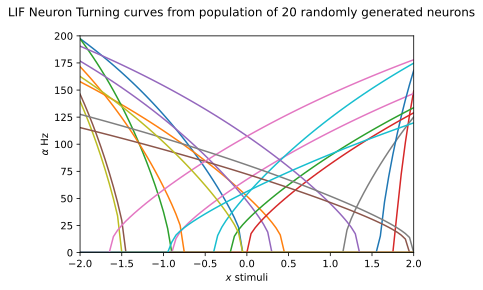

In [512]:
# we want 20 neurons
num_neurons = 20
# with this default state
state = {
    "min_rate": 100,
    "max_rate": 200,
    "encoder": [-1, 1],
    "tau_ref": 2 / 1000,
    "tau_rc": 20 / 1000,
    "min_x_int": -2,
    "max_x_int": 2,
}

# create a population of 20 neurons with the default states
ensemble1 = Population(
    num_neurons,
    state=state,
)
S = 81  # samples
X = np.linspace(-2, 2, S)
curves = np.array(ensemble1.get_curves(X))

plt.figure()
plt.suptitle(
    "LIF Neuron Turning curves from population of 20 randomly generated neurons"
)
for curve in curves:
    plt.plot(X, curve)
plt.xlabel("$x$ stimuli")
plt.ylabel("$\\alpha$ Hz")
plt.xlim([-2, 2])
plt.ylim([0, 200])
plt.show()

**b) Decoder and error computation.** Compute the decoders and plot $(x-\hat{x})$. When computing decoders, take into account noise ($\sigma=0.1 \cdot 200\,\mathrm{Hz}$). When computing $\hat{x}$, add random Gaussian noise with $\sigma=0.1 \cdot 200\,\mathrm{Hz}$ to the activity. Report the Root Mean-Squared Error (RMSE).


Decoders with noise ----------
[-0.00068122 -0.00101302 -0.00127595  0.0001646  -0.00072472 -0.00063046
  0.0018315   0.0016065  -0.00056462  0.00216541  0.00076354 -0.00112071
  0.00170102  0.00196816 -0.00276315 -0.00117113  0.00196086 -0.00127341
 -0.00057206  0.00146749]
-----------------


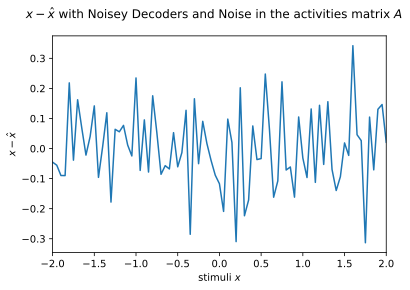

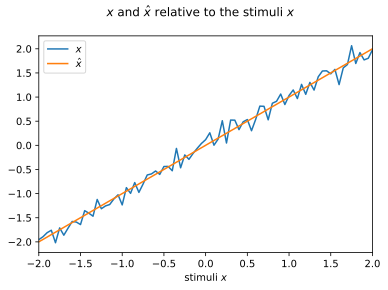

RMSE ----------
0.12919565696552784
-----------------


In [513]:
A = curves
X = X
noise_stdev = 0.1 * 200
w_noise = np.random.normal(scale=noise_stdev, size=np.shape(A))
A_NOISE = A + w_noise
N = len(X)
n = num_neurons
# find decoders via least squares solution
D = np.linalg.lstsq(
    A @ A.T + 0.5 * N * np.square(noise_stdev) * np.eye(n), A @ X.T, rcond=None
)[0]

print_block("Decoders with noise", D)

X_hat = np.dot(D, A_NOISE)
X = np.array(X)
E = X - X_hat

plt.figure()
plt.suptitle("$x-\hat{x}$ with Noisey Decoders and Noise in the activities matrix $A$")
plt.plot(X, E)
plt.xlabel("stimuli $x$")
plt.ylabel("$x-\hat{x}$")
plt.xlim([-2, 2])
plt.show()

plt.figure()
plt.suptitle("$x$ and $\hat{x}$ relative to the stimuli $x$")
x1 = plt.plot(X, X_hat, label="$x$")
x2 = plt.plot(X, X, label="$\hat{x}$")
plt.xlim([-2, 2])
plt.legend(handles=[x1, x2], labels=[])
plt.xlabel("stimuli $x$")
plt.show()


print_block("RMSE", rmse(X, X_hat))

# 2. Decoding from two spiking neurons

**a) Synaptic filter.** Plot the post-synaptic current
$$
			h(t)= \begin{cases}
				0 & \text{if } t < 0 \,, \\
				\frac{e^{-t/\tau}}{\int_0^\infty e^{-t'/\tau} \mathrm{d}t'} & \text{otherwise} \,.
			\end{cases}
		$$


In [514]:
# ✍ <YOUR SOLUTION HERE>

**b) Decoding using a synaptic filter.** Plot the original signal $x(t)$, the spikes, and the decoded $\hat{x}(t)$ all on the same graph.


In [515]:
# ✍ <YOUR SOLUTION HERE>

**c) Error analysis.** Compute the RMSE of the decoding.


In [516]:
# ✍ <YOUR SOLUTION HERE>

# 3. Decoding from many neurons

**a) Exploring the error for an increasing neuron count.** Plot the Root Mean-Squared Error as the number of neurons increases, on a log-log plot. Try $8$ neurons, $16$ neurons, $32$, $64$, $128$, up to $256$. For the RMSE for a particular number of neurons, average over at least $5$ randomly generated groups of neurons. For each group of neurons, randomly generate the signal $x(t)$. Use the same parameters as in question 2.


In [517]:
# ✍ <YOUR SOLUTION HERE>

**b) Discussion.** Discuss your results. What is the systematic relationship between the neuron count and the error?


✍ \<YOUR SOLUTION HERE\>


# 4. Connecting two groups of neurons

**a) Computing a function.** Show the behaviour of the system with an input of $x(t)=t-1$ for $1\,\mathrm{s}$ (a linear ramp from $-1$ to $0$). Plot the ideal $x(t)$ and $y(t)$ values, along with $\hat{y}(t)$.


In [518]:
# ✍ <YOUR SOLUTION HERE>

**b) Step input.** Repeat part (a) with an input that is ten randomly chosen values between -1 and 0, each one held for 0.1 seconds (a randomly varying step input)


In [519]:
# ✍ <YOUR SOLUTION HERE>

**c) Sinusoidal input.** Repeat part (a) with an input that is $x(t)=0.2\sin(6\pi t)$.


In [520]:
# ✍ <YOUR SOLUTION HERE>

**d) Discussion.** Briefly discuss the results for this question. Does the output match the ideal output? What kind of deviations do you see and why do those exist?


✍ \<YOUR SOLUTION HERE\>


# 5. Connecting three groups of neurons

**a) Sinusoidal input.** Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for an input of $x(t)=\cos(3\pi t)$ and $y(t)=0.5 \sin (2 \pi t)$ (over $1\,\mathrm{s}$).


In [521]:
# ✍ <YOUR SOLUTION HERE>

**b) Random input.** Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for a random input over $1\,\mathrm{s}$. For $x(t)$ use a random signal with a limit of $8\,\mathrm{Hz}$ and $\mathtt{rms}=1$. For $y(t)$ use a random signal with a limit of $5\,\mathrm{Hz}$ and $\mathtt{rms}=0.5$.


In [522]:
# ✍ <YOUR SOLUTION HERE>

# 6. Computing with vectors

**a) Constant inputs.** Plot the decoded output $\hat{w}(t)$ and the ideal $w$ for
$$x =(0.5,1), \quad y = (0.1,0.3), \quad z =(0.2,0.1), \quad q = (0.4,-0.2) \,.$$


In [523]:
# ✍ <YOUR SOLUTION HERE>

**b) Sinusoidal input.** Produce the same plot for
$$x =(0.5,1), \quad y = (\sin(4\pi t),0.3), \quad z =(0.2,0.1), \quad q = (\sin(4\pi t),-0.2) \,.$$


In [524]:
# ✍ <YOUR SOLUTION HERE>

**c) Discussion.** Describe your results and discuss why and how they stray from the expected answer.


✍ \<YOUR SOLUTION HERE\>
